In [1]:
import csv
import math
import gzip
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd

import gzip
import pickle
import decimal

In [2]:
lineNames = ["SC05","A900","A975","A976", "PO88"]

scaffNames = ["scaffold_6540","scaffold_6500","scaffold_6680","scaffold_6496",
              "scaffold_6473","scaffold_6328","scaffold_6308","scaffold_6359"]

scaffSizes = [34148556,32352404,24764193,26866924,
              16943266,4453435,3356042,4525533]

bedFile = "/home/miguel/Desktop/HonoursProject/Data/forMiguel/gimble.mainScaffs.bed"
genotypesFile = '/home/miguel/Desktop/HonoursProject/Data/forMiguel/inbredGenotypes.txt'
dataSaveFile = "/home/miguel/Desktop/HonoursProject/Data/forMiguel/scaffGenotypeDict"

In [3]:
scaffIndexDict={a:b for (a,b) in  list(zip(scaffNames,range(len(scaffNames))))}

print(scaffIndexDict)

strainIndexDict={a:b for (a,b) in  list(zip(lineNames,range(len(lineNames))))}

print(strainIndexDict)

{'scaffold_6540': 0, 'scaffold_6500': 1, 'scaffold_6680': 2, 'scaffold_6496': 3, 'scaffold_6473': 4, 'scaffold_6328': 5, 'scaffold_6308': 6, 'scaffold_6359': 7}
{'SC05': 0, 'A900': 1, 'A975': 2, 'A976': 3, 'PO88': 4}


In [4]:
def check_genotypes(gl):
    ggl = [x.strip().split("/" or "|") for x in gl]
    ggl = [ 1 if (('.' in x) or (len(x)<2)) else (1 if x[0]==x[1] else 2) for x in ggl ]
    return(ggl)

In [5]:
def count_sites(arr): #this is an array of positions for a particular strain
    (unique,counts) = np.unique(arr,return_counts=True)
    zeros = 0
    ones = 0
    twos = 0
    for xl in list(zip(unique,counts)):
        if xl[0] == 0:
            zeros = xl[1]
        if xl[0] == 1:
            ones = xl[1]
        if xl[0] == 2:
            twos = xl[1]
    return([zeros,ones,twos])

def calc_diversity(winArr): # a window of sites, each has the genotypes
    countsByStrain = [count_sites(x) for x in winArr.transpose()] #transpose to get strain-wise site list
    divByStrain = [0 if (x[1]+x[2])==0 else 1.0/2*x[2]/(x[1]+x[2]) for x in countsByStrain]
    return(divByStrain)

In [6]:

with gzip.open(dataSaveFile,mode="rb") as infile:
    scaffGenotypeDict = pickle.load(infile)

In [63]:
testchr = scaffGenotypeDict['scaffold_6496'];
chrName = 'Chr3'
chunkSize = 50000
windowWidth = 3 #as a number of chunks per window
print("window size \t")
print(chunkSize*windowWidth)

stride = 1  #should probably keep as 1

numChunks = int(len(testchr)/chunkSize)
print("\n number of chunks in chromosome")
print(numChunks)
chunks = np.array_split(testchr,numChunks);

chunkSizeTrue = len(chunks[1])
print("\n true chunk size after  array split")
print(chunkSizeTrue)

print("\n true window size")
print(chunkSizeTrue*windowWidth)

divCalc = [calc_diversity(x) for x in chunks]
divCalc = np.asarray(divCalc)
#returns list of windows, each window a list of per-strain results. 
#take the transpose to get each strain as a list of the windows
allcounts = [[count_sites(y) for y in x.transpose()] for x in chunks]
# print(allcounts[1])
coverage = [(chunkSizeTrue-x[0])/chunkSizeTrue for x in [y[0]for y in allcounts]]

window size 	
150000

 number of chunks in chromosome
537

 true chunk size after  array split
50032

 true window size
150096


In [64]:
divCalcByStrain = divCalc.transpose()

windows = [] #windows in terms of left and right [l,r] indices of the underlying chunks
for x in range(0,numChunks-(windowWidth-stride),stride):
    windows.append([x,x+windowWidth])

res = [   [[] for x in range(numChunks)] for y in range(len(lineNames)) ]
    #each item in res will be for a different strain.  
    # for each strain, we go through the (overlapping) windows. Each window gets an average score from underlying chunks
    # each of the chunks is a list of the average values from the windows that cover it
    # the chunks at the begiining and end will have fewer scores (fewer overlapping windows)
for strainIdx in range(len(lineNames)):    
    for [l,r] in windows: 
        #calc average diversity in this window as mean diversity in underlying chunks
        thisWinDiv = divCalcByStrain[strainIdx][l:r]
        total = sum(thisWinDiv)
        mean = total/len(thisWinDiv)
        #for each chunk in this window, append the corresponding score.We drop the last few windows 
        for x in range(l,r,1):
            res[strainIdx][x].append(mean)
            
overlapingDivCalcByStrain = [[ max(x) for x in thisRes] for thisRes in res]
 #i.e. we will give any chunk the highest score from the windows which contain it
 # this makes sense for spanning data
 # we could also take the average or any other function.
overlapingDivCalcByStrain = np.asanyarray(overlapingDivCalcByStrain)

strain:  SC05
coverage


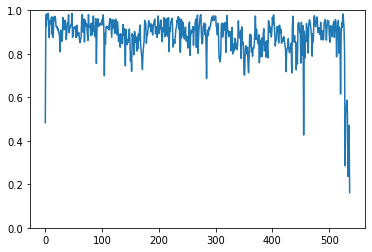

non-overalapping


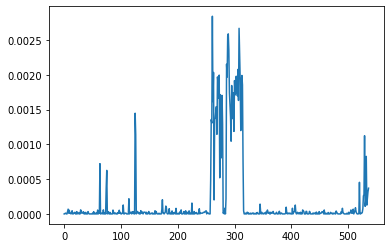

overlapping,take chunk div as mean


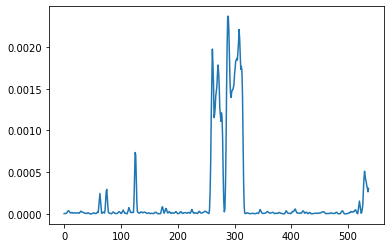

overlapping, take chunk div as max


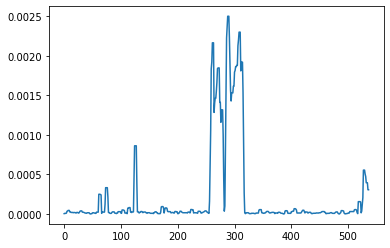

In [77]:
thisStrainIdx = 0
print("strain:  "+lineNames[thisStrainIdx])

print("coverage")
plt.plot(coverage)
plt.ylim([0,1])
plt.show()

print("non-overalapping")
plt.plot(divCalcByStrain[thisStrainIdx])
plt.show()


print("overlapping,take chunk div as mean")
overlapingDivCalcByStrain = [[ sum(x)/float(len(x)) for x in thisRes] for thisRes in res]

plt.plot(overlapingDivCalcByStrain[thisStrainIdx])
plt.show()


print("overlapping, take chunk div as max")
overlapingDivCalcByStrain = [[ max(x) for x in thisRes] for thisRes in res]
plt.plot(overlapingDivCalcByStrain[thisStrainIdx])
plt.show()

plotting all strains at once


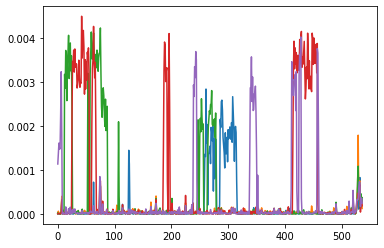

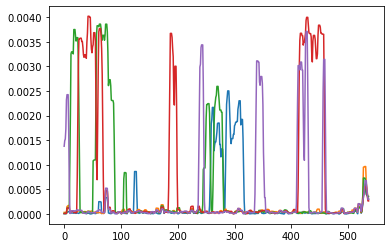

In [78]:
print("plotting all strains at once")
plt.plot(divCalcByStrain.transpose())
plt.show()

thisData = np.asanyarray(overlapingDivCalcByStrain)
plt.plot(thisData.transpose())
plt.show()

0.074487895716946


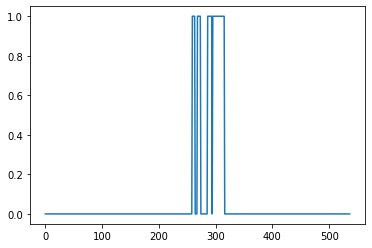

In [79]:
threshold = 0.0015
hetero_or_not =[]
for chunk in overlapingDivCalcByStrain[thisStrainIdx]:
    if chunk >= threshold:
        hetero_or_not.append(1)
    else:
        hetero_or_not.append(0)

plt.plot(hetero_or_not)
#plt.savefig(r'/home/miguel/Desktop/HonoursProject/DiversityThresholds/Sliding_windows/' + str(chunkSize*windowWidth) + '/' + str(threshold) + '/' + chrName + '_' + lineNames[thisStrainIdx]  + '_ '+ 'tract_lengths.png')
plt.show
print(sum(hetero_or_not)/len(hetero_or_not))

In [56]:
#see the positions where the breakpoints occur in the overlapping chromosomes
len(hetero_or_not)
positions = list(range(1,683))
df = pd.DataFrame(hetero_or_not)
df2 = pd.DataFrame(positions)
df3 = pd.concat([df, df2], axis=1, join="inner")

In [ ]:
df = pd.DataFrame(hetero_or_not)
result = pd.concat([df, df3], axis=1, join="inner")
result

In [17]:
result.to_csv('/home/miguel/Desktop/HonoursProject/joe.csv')

In [127]:
def arraytostring(_):
    str1 = ''
    for element in _:
        str1 += element
    return str1

hetero_or_not = str(hetero_or_not)
hetero_or_not = arraytostring(hetero_or_not)
hetero_or_not = hetero_or_not.replace(',','')
hetero_or_not = hetero_or_not.replace(' ','')
listOnes = hetero_or_not.split('0')
hetero_or_not = [len(y) for y in listOnes if y !='']
hetero_or_not = hetero_or_not[1:-1]

tractLengths = []

for tract in hetero_or_not:
    tractLengths.append((chunkSizeTrue*tract)/len(testchr))
np.savetxt(r'/home/miguel/Desktop/HonoursProject/DiversityThresholds/Sliding_windows/' + str(chunkSize*windowWidth) + '/' + str(threshold) + '/' + chrName + '_' + lineNames[thisStrainIdx]  + '_ '+ 'tract_lengths.txt',tractLengths)

In [128]:
tractLengths

[0.013035507898112936,
 0.01489772331212907,
 0.02420880038220974,
 0.02048436955417747,
 0.011173292484096802,
 0.009311077070080668]

In [118]:
hetero_or_not

[16, 33, 7, 15]

In [83]:
#calculating diversity
path_to_tracts = '/home/miguel/Desktop/HonoursProject/DiversityThresholds/Sliding_windows/' + str(chunkSize*windowWidth) + '/' + str(threshold)
inputFiles = os.listdir(path_to_tracts)
inputFiles = [ x for x in inputFiles if x.endswith('.txt')]
inputFiles

['Chr3_A975_ tract_lengths.txt',
 'Chr2_A975_ tract_lengths.txt',
 'Chr4_SC05_ tract_lengths.txt',
 'Chr2_PO88_ tract_lengths.txt',
 'Chr3_PO88_ tract_lengths.txt',
 'Chr4_A900_ tract_lengths.txt',
 'Chr3_A976_ tract_lengths.txt',
 'Chr2_A976_ tract_lengths.txt',
 'Chr3_A900_ tract_lengths.txt',
 'Chr3_SC05_ tract_lengths.txt',
 'Chr2_A900_ tract_lengths.txt',
 'Chr2_SC05_ tract_lengths.txt']

(array([28., 11.,  4.,  1.,  0.,  1.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,  0.,  1.]),
 array([0.004398897569783039, 0.019970994966815, 0.03554309236384696,
        0.05111518976087892, 0.06668728715791088, 0.08225938455494283,
        0.0978314819519748, 0.11340357934900676, 0.12897567674603871,
        0.14454777414307068, 0.16011987154010263, 0.1756919689371346,
        0.19126406633416657, 0.2068361637311985, 0.22240826112823048,
        0.23798035852526242, 0.25355245592229436, 0.2691245533193264,
        0.2846966507163583, 0.3002687481133902, 0.31584084551042224,
        0.33141294290745416, 0.3469850403044862, 0.3625571377015181,
        0.3781292350985501, 0.39370133249558203, 0.40927342989261395,
        0.424845527289646, 0.4404176246866779, 0.4559897220837099,
        0.4715618194

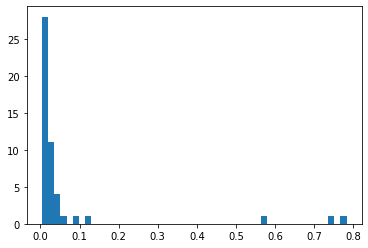

In [84]:
tract_lengths = []
for file in inputFiles:
    indiv_file = pd.read_csv('/home/miguel/Desktop/HonoursProject/DiversityThresholds/Sliding_windows/' + str(chunkSize*windowWidth) + '/' + str(threshold) +'/' + file,names=["length"], sep='\t')
    infiv_file = indiv_file.values.tolist()
    tract_lengths.append(indiv_file.values)
#df = DataFrame (tract_lengths, columns=['length'])
tract_lengths = np.concatenate(tract_lengths, axis = 0)
plt.hist(tract_lengths,bins = 50)
#plt.savefig(path_to_save + '/tract_length_distribution.png')

In [85]:
sum(tract_lengths/20)

array([0.15660154218592193], dtype=object)